In [1]:
from sklearn import tree, metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# load data cleaned from rscript
sc_df = pd.read_csv('../data/sc_decisions_final.csv')

# fill missing values as they are legitimate
sc_df = sc_df.fillna("N/A")

# remove decision year since unneeded here
sc_df = sc_df.drop(['yearDecision'], axis=1)

print(sc_df.shape)

sc_df.head()

(14047, 23)


,c_chief,c_lcDisagreement,c_lcDispositionDirection,c_issueArea,c_adminActionBool,c_oralArgBool,c_reargBool,c_decisionTime,c_formerCourt,c_caseOriginRegion,...,e_decisionPresidentParty,e_JCApproval,j_justiceGender,j_justiceDecisionAgeBand,j_justiceRegion,j_justiceReligion,j_justiceEthnicity,j_justicePresidentParty,j_justiceVotesAppointed,direction
0,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,...,Democrat,Approve,Male,65+,Midwest,Protestant,Caucasian,Republican,<75%,Liberal
1,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,...,Democrat,Approve,Male,65+,Midwest,Protestant,Caucasian,Republican,>=75%,Liberal
2,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,...,Democrat,Approve,Female,65+,West,Protestant,Caucasian,Republican,>=75%,Liberal
3,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,...,Democrat,Approve,Male,0-65,Northeast,Catholicism,Caucasian,Republican,>=75%,Conservative
4,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,...,Democrat,Approve,Male,0-65,West,Catholicism,Caucasian,Republican,>=75%,Liberal


In [9]:
# select explanatory and response variables
X = sc_df.loc[:, sc_df.columns != 'direction']
y = sc_df[['direction']].astype("category")

# encode target
y = y.apply(lambda x: x.cat.codes)

# check target encoding
# y.apply(lambda x: x.cat.categories) 

# treat booleans and multiple categories differently
cat_vars = list(X.columns[X.nunique() > 2])
bool_vars = list(X.columns[X.nunique() == 2])

# encode categorical features
X_cat = pd.get_dummies(X[cat_vars], columns = cat_vars)
X_bool = pd.get_dummies(X[bool_vars], columns = bool_vars, drop_first = True)
X = pd.concat([X_cat, X_bool], axis = 1)


In [10]:
# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (10535, 55)
Testing split input-  (3512, 55)


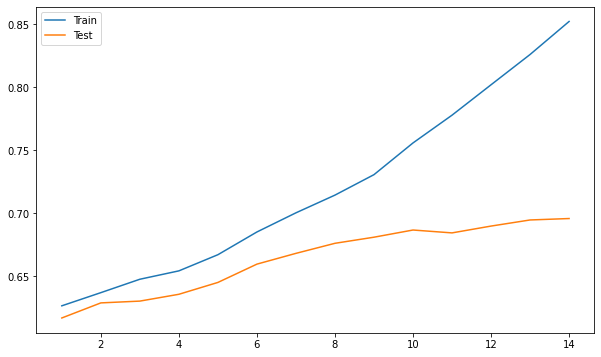

In [11]:
train_scores = []
test_scores = []

# number of trees
depths = [i for i in range(1, 15)] 

# evaluate forest per num trees
for i in depths:
    model = RandomForestClassifier(max_depth=i, n_jobs=-1, random_state = 42)
    model.fit(X_train, np.ravel(y_train))
    
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)


# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()
plt.savefig('../output/max_depth_forest.png')

# around 5

In [19]:
# wide range considerations for hyperparameters

# num trees in forest
n_estimators = list(range(100, 1000+1, 100))

# num features to consider at every split
max_features = [5, 15, 20, 25]

# max depth of each tree
max_depth = [5]

# min num samples to split a node
min_samples_split = [2, 5, 10]

# min num samples at each leaf node
min_samples_leaf = [2, 4, 6, 8, 10]

# whether bootstrap samples are used
bootstrap = [True, False]

# random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': [5, 15, 20, 25], 'max_depth': [5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4, 6, 8, 10], 'bootstrap': [True, False]}


In [20]:
# tune with randomized grid search
model = RandomForestClassifier(random_state = 42)

# random search of parameters with 3 fold CV
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3,
                                  verbose=2, random_state = 42, n_jobs = -1)
# fit the random search model
model_random.fit(X_train, np.ravel(y_train))

model_random.best_params_ # these are narrowed down possible parameter values

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 25,
 'max_depth': 5,
 'bootstrap': True}

In [21]:
 def evaluate(model, x, y):
    y_hat = model.predict(x)
    accuracy = metrics.accuracy_score(y, y_hat)
    return accuracy
    
# evaluate best random model
best_random = model_random.best_estimator_
random_acc = evaluate(best_random, X_test, y_test)
print('best random model test: {:0.2f}%'.format(100 * random_acc))

# base model
base_model = RandomForestClassifier(random_state = 42, max_depth = 5)
base_model.fit(X_train, np.ravel(y_train))
base_acc = evaluate(base_model, X_test, y_test)
print('base model test: {:0.2f}%'.format(100 * base_acc))

print('Improvement of {:0.2f}%'.format(100 * (random_acc - base_acc) / base_acc)) # (new - old)/old

best random model test: 67.06%
base model test: 64.52%
Improvement of 3.93%


In [22]:
# further narrow down values of hyperparameters
# random search should be giving us good approximation

# create parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [5], 
    'max_features': [20, 25, 30],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 300, 400]
}

print(param_grid)

{'bootstrap': [True], 'max_depth': [5], 'max_features': [20, 25, 30], 'min_samples_leaf': [2, 4, 6], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 300, 400]}


In [35]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid,cv = 3, 
                           n_jobs = -1, verbose = 2)

# fit grid search to the data
grid_search.fit(X_train, np.ravel(y_train))

grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': True,
 'max_depth': 5,
 'max_features': 25,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [24]:
best_grid = grid_search.best_estimator_
grid_acc = evaluate(best_grid, X_test, y_test)
print('best model test: {:0.2f}%'.format(100 * grid_acc))

print('Improvement of {:0.2f}%.'.format( 100 * (grid_acc - base_acc) / base_acc))

best model test: 67.06%
Improvement of 3.93%.


final model train: 67.83%
final model test: 67.06%


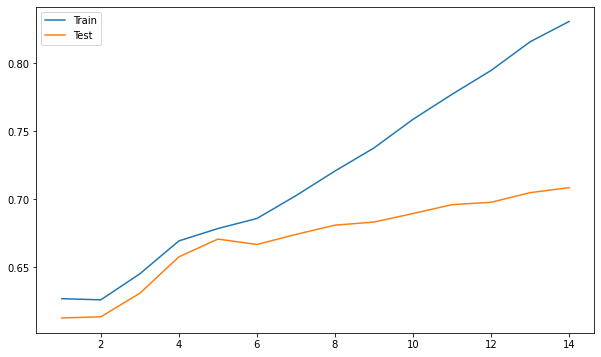

In [25]:
# quick overfitting test check
yhat_train = best_grid.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, yhat_train)
print('final model train: {:0.2f}%'.format(100 * train_accuracy))

yhat_test = best_grid.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, yhat_test)
print('final model test: {:0.2f}%'.format(100 * test_accuracy))

# plot
train_scores = []
test_scores = []

# number of trees
depths = [i for i in range(1, 15)] 

# evaluate forest per num trees
for i in depths:
    model = RandomForestClassifier(max_depth=i, n_jobs=-1, random_state = 42, bootstrap = True, max_features = 25, 
                                   min_samples_leaf = 2, min_samples_split = 5, n_estimators = 200)
    model.fit(X_train, np.ravel(y_train))
    
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)


# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()
plt.savefig('../output/overfit_rf.png')

# not bad 

In [26]:
plt.figure(figsize=(200,120)) 
plot_tree(best_grid[0], feature_names = X.columns, 
          class_names =["Conservative", "Liberal"] , filled = True , precision = 4, rounded = True)
plt.savefig('../output/first_rf_tree.png')

In [27]:
# feature importances by impurity score
importances = best_grid.feature_importances_

pd.DataFrame(data = {
    'feature': X.columns,
    'importance': importances
}).sort_values("importance", ascending = False).head(10)

,feature,importance
4,c_lcDispositionDirection_Liberal,0.272772
38,j_justiceReligion_Catholicism,0.135552
3,c_lcDispositionDirection_Conservative,0.113787
53,j_justicePresidentParty_Republican,0.066011
19,c_decisionTime_0-30 Days,0.060129
43,c_oralArgBool_1,0.050967
8,c_issueArea_Criminal Procedure,0.036926
45,c_formerCourt_1,0.028745
50,j_justiceGender_Male,0.026668
40,j_justiceReligion_Protestant,0.022553


In [28]:
# feature importance by feature permutations
from sklearn.inspection import permutation_importance

perm_importances = permutation_importance(best_grid, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

perm_importances_mean = pd.Series(perm_importances.importances_mean, index=X.columns)
perm_importances_mean.to_frame().rename(columns={0: "importance"}).sort_values("importance",
                                                                               ascending = False).head(10)


[CV] END bootstrap=False, max_depth=6, max_features=15, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   4.7s
[CV] END bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=False, max_depth=5, max_features=15, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   2.9s
[CV] END bootstrap=False, max_depth=5, max_features=5, min_samples_leaf=6, min_samples_split=10, n_estimators=1000; total time=   2.6s
[CV] END bootstrap=False, max_depth=5, max_features=25, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   6.5s
[CV] END bootstrap=True, max_depth=5, max_features=15, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   3.6s
[CV] END bootstrap=False, max_depth=5, max_features=20, mi

,importance
c_lcDispositionDirection_Liberal,0.043280
j_justiceReligion_Catholicism,0.025598
c_issueArea_Criminal Procedure,0.023121
j_justicePresidentParty_Republican,0.016116
j_justiceReligion_Protestant,0.011617
c_decisionTime_0-30 Days,0.008115
j_justiceGender_Male,0.007688
c_lcDispositionDirection_Conservative,0.006634
c_oralArgBool_1,0.005780
c_formerCourt_1,0.004983


final model train: 67.83%
final model test: 67.06%
Tuned Model
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1815
           1       0.63      0.76      0.69      1697

    accuracy                           0.67      3512
   macro avg       0.68      0.67      0.67      3512
weighted avg       0.68      0.67      0.67      3512

Base Model
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1815
           1       0.63      0.65      0.64      1697

    accuracy                           0.65      3512
   macro avg       0.65      0.65      0.65      3512
weighted avg       0.65      0.65      0.65      3512



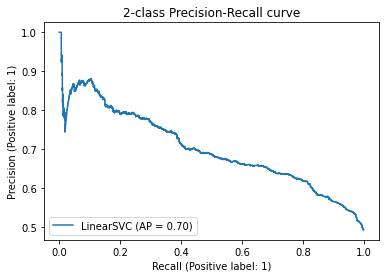

In [41]:
# tuned model (instead of running all of the above)
final_model = RandomForestClassifier(max_depth = 5, n_jobs = -1, random_state = 42, bootstrap = True, max_features = 25, 
                                   min_samples_leaf = 2, min_samples_split = 5, n_estimators = 200)
final_model.fit(X_train, np.ravel(y_train))
    
# evaluate train dataset
yhat_train = final_model.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, yhat_train)
print('final model train: {:0.2f}%'.format(100 * train_accuracy))

# evaluate test dataset
yhat_test = final_model.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, yhat_test)
print('final model test: {:0.2f}%'.format(100 * test_accuracy))

# other metrics for performance 
print("Tuned Model")
print(metrics.classification_report(y_test, yhat_test))

base_yhat_test = base_model.predict(X_test)
print("Base Model")
print(metrics.classification_report(y_test, base_yhat_test))

# precision recall curve
display = metrics.PrecisionRecallDisplay.from_estimator(final_model, X_test, y_test, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.savefig('../output/Precision-Recall.png')

In [ ]:
# resources
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
# https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/